# BOB dataset -  FD calculation

- Segmentation: using the existing segmentation that comes with the dataset
- FD: per region; left/right comparison; FD over age

In [116]:
import nibabel as nib
import pandas as pd 
import utils as ut
from natsort import natsort_keygen
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
import utils as ut
import re
import math
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

## Data  

In [19]:
#example file
t1_scan = '../../Datasets/BOB/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz'

Checking the data from the file  

In [20]:
im = nib.load(t1_scan)
print(im.header) 

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 16384
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 182 218 182   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'6.0.4:ddd0a010')
aux_file        : np.bytes_(b'')
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.

In [21]:
csvpath = '../../Datasets/BOB/phenotype/sessions.tsv'
ds_info = pd.read_csv(csvpath, sep ='\t')
ds_info.head()

,participant_id,session_id,age,gestational_age_at_birth,sex
0,sub-116056,ses-3mo,3.6,40.4,Male
1,sub-116845,ses-3mo,3.6,37.7,Female
2,sub-116845,ses-6mo,6.5,37.7,Female
3,sub-176427,ses-5mo,5.0,41.7,Female
4,sub-198202,ses-5mo,5.9,40.1,Male


Some 2D visualization

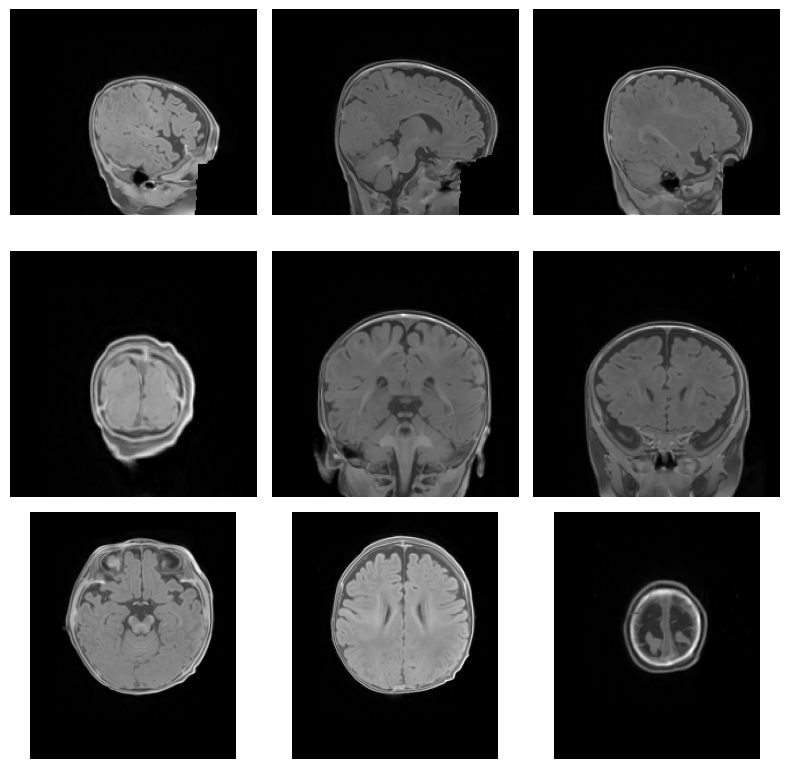

In [22]:
plot = ut.visualize_nifti_depth(t1_scan)

## Load segmentations

In [23]:
img = nib.load(r'..\..\Datasets\BOB\sub-116056\ses-3mo\anat\sub-116056_ses-3mo_space-INFANTMNIacpc_desc-aseg_dseg.nii.gz')
array = img.get_fdata()
array.shape

(182, 218, 182)

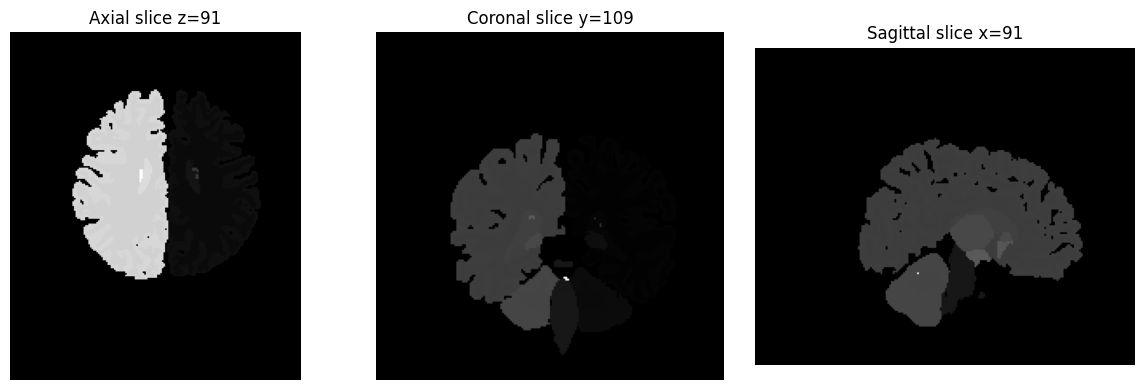

In [24]:
data = img.get_fdata()

# Pick slice indices (e.g. middle of each axis)
i_mid = data.shape[0] // 2
j_mid = data.shape[1] // 2
k_mid = data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Axial (XY plane, varying Z)
axes[0].imshow(np.rot90(data[:, :, k_mid]), cmap="gray")
axes[0].set_title(f'Axial slice z={k_mid}')

# Coronal (XZ plane, varying Y)
axes[1].imshow(np.rot90(data[:, j_mid, :]), cmap="gray")
axes[1].set_title(f'Coronal slice y={j_mid}')

# Sagittal (YZ plane, varying X)
axes[2].imshow(np.rot90(data[i_mid, :, :]), cmap="gray")
axes[2].set_title(f'Sagittal slice x={i_mid}')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
BOB_idx_lbl = pd.read_csv('../../Datasets/BOB/dseg.tsv', sep ='\t')
BOB_idx_lbl.head()

,index,name,color
0,0,Unknown,#000000
1,1,Left-Cerebral-Exterior,#4682b4
2,2,Left-Cerebral-White-Matter,#f5f5f5
3,3,Left-Cerebral-Cortex,#cd3e4e
4,4,Left-Lateral-Ventricle,#781286


In [36]:
# build the colormap
labels     = BOB_idx_lbl['index'].values  
color_list = BOB_idx_lbl['color'].tolist()            
cmap       = ListedColormap(color_list)

# build a norm so that each integer goes to one entry of the cmap
bounds = np.concatenate([labels, [labels[-1] + 1]])
norm   = BoundaryNorm(bounds, cmap.N)

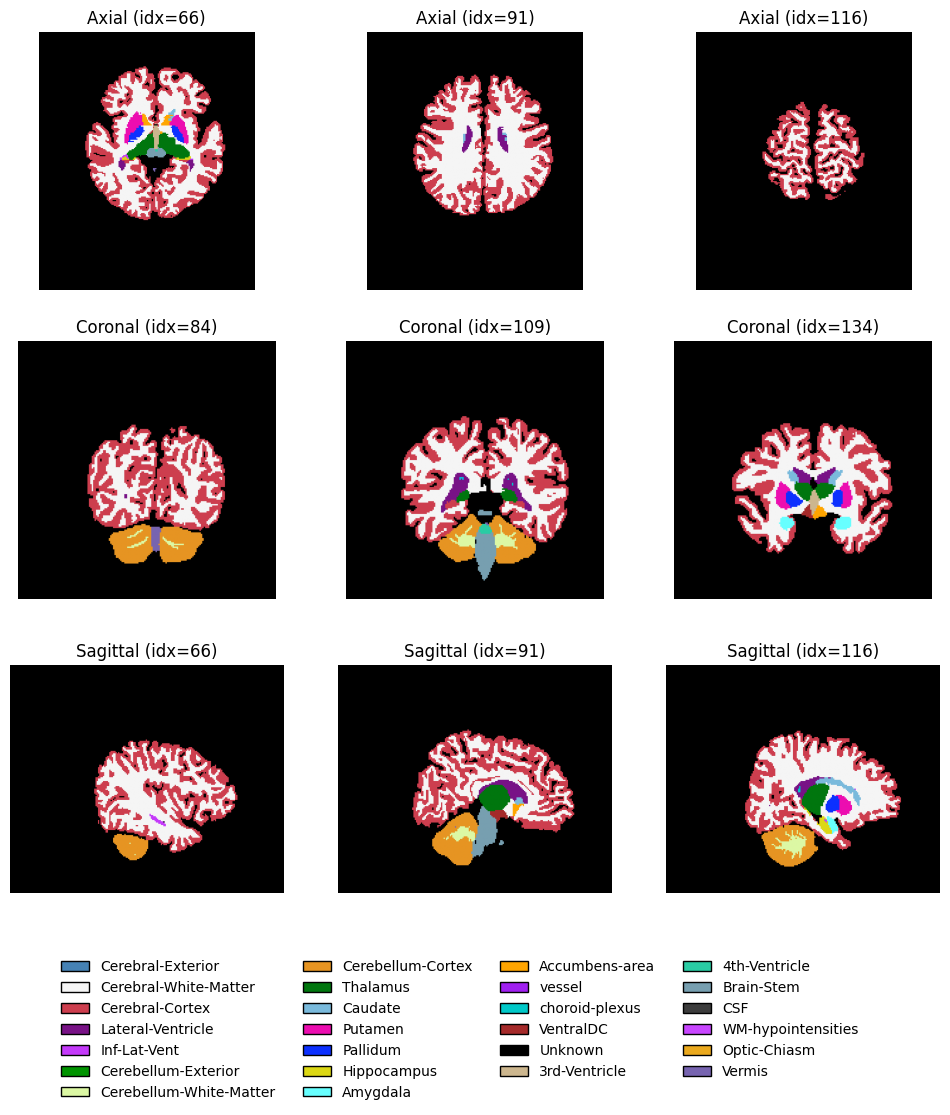

In [ ]:
x_mid, y_mid, z_mid = np.array(data.shape) // 2

# define offsets (in voxels) around the center
offsets = [-25, 0, +25]

# set up the figure: 3 rows (axial, coronal, sagittal)
fig, axes = plt.subplots(3, len(offsets), figsize=(12, 12))

for row, (orient, center) in enumerate([
    ("axial",   z_mid),
    ("coronal", y_mid),
    ("sagittal",x_mid),
]):
    for col, off in enumerate(offsets):
        idx = center + off
        if orient == "axial":
            sl = data[:, :, idx]
        elif orient == "coronal":
            sl = data[:, idx, :]
        else:  # sagittal
            sl = data[idx, :, :]

        ax = axes[row, col]
        ax.imshow(np.rot90(sl), cmap=cmap, norm=norm)
        ax.set_title(f"{orient.capitalize()} (idx={idx})")
        ax.axis("off")

BOB_idx_lbl['region'] = BOB_idx_lbl['name'].str.replace('^Left-', '', regex=True) \
                        .str.replace('^Right-', '', regex=True)

# pick only one entry per lateralized region
sides       = BOB_idx_lbl[BOB_idx_lbl['name'].str.startswith(('Left-','Right-'))]
unique_sides = sides.drop_duplicates('region')

# keep all non-lateral entries intact
non_sides    = BOB_idx_lbl[~BOB_idx_lbl['name'].str.startswith(('Left-','Right-'))]

legend_df   = pd.concat([unique_sides, non_sides], ignore_index=True)

# build legend handles
handles = [
    Patch(facecolor=row['color'], edgecolor='black', label=row['region'])
    for _, row in legend_df.iterrows()
]

# draw the legend
ncol = 4  
fig.legend(
    handles=handles,
    loc='lower center',
    ncol=ncol,
    bbox_to_anchor=(0.5, -0.02),
    frameon=False
)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [6]:
index_to_label = dict(zip(BOB_idx_lbl['index'], BOB_idx_lbl['name']))

### Write all the masks

In [ ]:
data_folder = Path("../../Datasets/BOB")

for win_seg in data_folder.rglob("*dseg.nii.gz"):
    sess_dir = win_seg.parent / "segmentation_outputs"
    sess_dir.mkdir(exist_ok=True)

    # load the segmentation volume
    img  = nib.load(str(win_seg))
    data = img.get_fdata().astype(int)

    # find all non‐zero labels
    labels = np.unique(data)
    labels = labels[labels != 0]
    print(f"[{win_seg.stem}] saving masks for labels: {labels}")

    # write one binary mask per label
    for lbl in labels:
        name = index_to_label.get(int(lbl))
        if not name:
            print(f"skipping unknown label {lbl}")
            continue

        mask     = (data == lbl).astype(np.uint8)
        mask_img = nib.Nifti1Image(mask, img.affine, img.header)
        mask_fp  = sess_dir / f"{lbl:03d}_{name}.nii.gz"
        nib.save(mask_img, str(mask_fp))
        print(f"wrote {mask_fp.name}")


[sub-116056_ses-3mo_space-INFANTMNIacpc_desc-aseg_dseg.nii] saving masks for labels: [  2   3   4   5   7   8  10  11  12  13  14  15  16  17  18  26  28  31
  41  42  43  44  46  47  49  50  51  52  53  54  58  60  63 172]
wrote 002_Left-Cerebral-White-Matter.nii.gz
wrote 003_Left-Cerebral-Cortex.nii.gz
wrote 004_Left-Lateral-Ventricle.nii.gz
wrote 005_Left-Inf-Lat-Vent.nii.gz
wrote 007_Left-Cerebellum-White-Matter.nii.gz
wrote 008_Left-Cerebellum-Cortex.nii.gz
wrote 010_Left-Thalamus.nii.gz
wrote 011_Left-Caudate.nii.gz
wrote 012_Left-Putamen.nii.gz
wrote 013_Left-Pallidum.nii.gz
wrote 014_3rd-Ventricle.nii.gz
wrote 015_4th-Ventricle.nii.gz
wrote 016_Brain-Stem.nii.gz
wrote 017_Left-Hippocampus.nii.gz
wrote 018_Left-Amygdala.nii.gz
wrote 026_Left-Accumbens-area.nii.gz
skipping unknown label 28
wrote 031_Left-choroid-plexus.nii.gz
wrote 041_Right-Cerebral-White-Matter.nii.gz
wrote 042_Right-Cerebral-Cortex.nii.gz
wrote 043_Right-Lateral-Ventricle.nii.gz
wrote 044_Right-Inf-Lat-Vent.ni

## Fractal dimension calculation

In [48]:
data_folder = Path("../../Datasets/BOB")

fd_results = []

# loop over whole-brain dseg files
for dseg in data_folder.rglob("*dseg.nii.gz"):
    participant = dseg.parents[2].name   
    session     = dseg.parents[1].name   
    print(f"processing {participant} {session}")

    # whole-brain FD
    fd, (mfs, Mfs), _ = ut.fractal_analysis(str(dseg), verbose=False)
    fd_results.append({
        'participant_id': participant,
        'session_id':    session,
        'label':         None,
        'name':          'whole_brain',
        'fd':            fd,
        'min_box_size':  mfs,
        'max_box_size':  Mfs
    })

    # per-mask FD
    mask_dir = dseg.parent / "segmentation_outputs"
    if not mask_dir.exists():
        print(f" no masks found for {dseg.stem}, skipping masks")
        continue

    for mask_fp in mask_dir.glob("*.nii.gz"):
        # extract label and name from filename "###_LabelName.nii.gz"
        stem = mask_fp.stem
        lbl_str, name = stem.split("_", 1)
        lbl = int(lbl_str)

        fd, (mfs, Mfs), _ = ut.fractal_analysis(str(mask_fp), verbose=False)
        fd_results.append({
            'participant_id': participant,
            'session_id':    session,
            'label':         lbl,
            'name':          name,
            'fd':            fd,
            'min_box_size':  mfs,
            'max_box_size':  Mfs
        })

processing sub-116056 ses-3mo
FD automatically selected: 2.7598
FD automatically selected: 2.4704
FD automatically selected: 2.4475
FD automatically selected: 1.5052
FD automatically selected: 1.3861
FD automatically selected: 2.1183
FD automatically selected: 2.4195
FD automatically selected: 2.3187
FD automatically selected: 2.0252
FD automatically selected: 2.0576
FD automatically selected: 1.9015
FD automatically selected: 1.8027
FD automatically selected: 1.6433
FD automatically selected: 2.297
FD automatically selected: 1.9098
FD automatically selected: 1.8722
FD automatically selected: 1.6556
FD automatically selected: 1.2167
FD automatically selected: 2.4731
FD automatically selected: 2.4512
FD automatically selected: 1.9636
FD automatically selected: 1.2739
FD automatically selected: 2.1091
FD automatically selected: 2.408
FD automatically selected: 2.3042
FD automatically selected: 1.9869
FD automatically selected: 2.086
FD automatically selected: 1.9196
FD automatically sele

In [54]:
df_fd = pd.DataFrame(fd_results)

# reorder columns
df_fd = df_fd[
    ['participant_id','session_id','label','name','fd','min_box_size','max_box_size']
]

df_fd_merged = df_fd.merge(
    ds_info,
    on=['participant_id', 'session_id'],
    how='left'
)

# remove any trailing ".nii"
df_fd_merged['name'] = (
    df_fd_merged['name']
      .str.replace(".nii", "")
)

df_fd_merged.head()

,participant_id,session_id,label,name,fd,min_box_size,max_box_size,age,gestational_age_at_birth,sex
0,sub-116056,ses-3mo,NaN,whole_brain,2.7598,1.0,16.0,3.6,40.4,Male
1,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,2.4704,1.0,16.0,3.6,40.4,Male
2,sub-116056,ses-3mo,3.0,Left-Cerebral-Cortex,2.4475,1.0,16.0,3.6,40.4,Male
3,sub-116056,ses-3mo,4.0,Left-Lateral-Ventricle,1.5052,4.0,64.0,3.6,40.4,Male
4,sub-116056,ses-3mo,5.0,Left-Inf-Lat-Vent,1.3861,1.0,16.0,3.6,40.4,Male


In [50]:
df_fd_merged.to_csv('BOB_fd_results.csv', index=False)

### EDA

In [123]:
n_missing = df_fd_merged['fd'].isna().sum()
print(f"Total missing FD values: {n_missing}")

Total missing FD values: 0


In [125]:
counts = df_fd_merged['name'].value_counts().reset_index()
counts.columns = ['name', 'count']
counts

,name,count
0,whole_brain,71
1,Left-Cerebral-White-Matter,71
2,Left-Cerebral-Cortex,71
3,Left-Lateral-Ventricle,71
4,Left-Inf-Lat-Vent,71
5,Left-Cerebellum-White-Matter,71
6,Left-Cerebellum-Cortex,71
7,Left-Thalamus,71
8,Left-Caudate,71
9,Left-Putamen,71


In [130]:
not_complete = counts.loc[counts['count'] < ds_info.shape[0], 'name'].values.tolist()
not_complete

['Left-choroid-plexus',
 'Right-choroid-plexus',
 'CSF',
 'Optic-Chiasm',
 'Right-vessel',
 'Vermis',
 'Left-vessel',
 'WM-hypointensities',
 'Left-Cerebral-Exterior',
 'Left-Cerebellum-Exterior']

### sorted FD plots

In [ ]:
df_fd_merged = pd.read_csv('BOB_fd_results.csv')

In [51]:
def assign_color(label_name):
    if 'Left' in label_name:
        return '#648FFF'
    elif 'Right' in label_name:
        return '#DC267F'
    elif 'whole_brain' in label_name:
        return '#FFB000'
    else:
        return 'grey'

In [132]:
# Determine sort order by median FD descending
region_order = (
    df_fd_merged.groupby('name')['fd']
      .median()
      .sort_values(ascending=False)
      .index
      .tolist()
)

colors = [assign_color(r) for r in region_order]

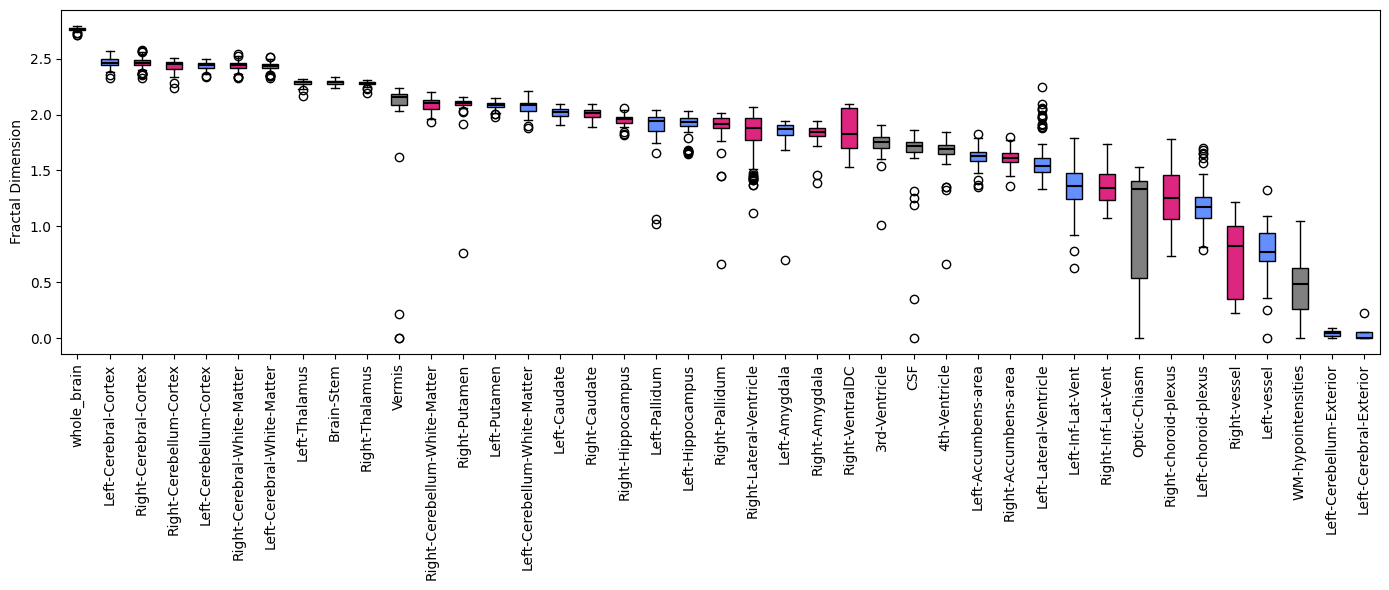

In [134]:
# Prepare data and colors
data_to_plot = [df_fd_merged[df_fd_merged['name'] == r]['fd'] for r in region_order]

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data_to_plot,
                 tick_labels=region_order,
                 patch_artist=True,
                 showfliers=True,
                 medianprops=dict(color='black', linewidth=1.5))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=90)
plt.ylabel("Fractal Dimension")
plt.tight_layout()
plt.show()

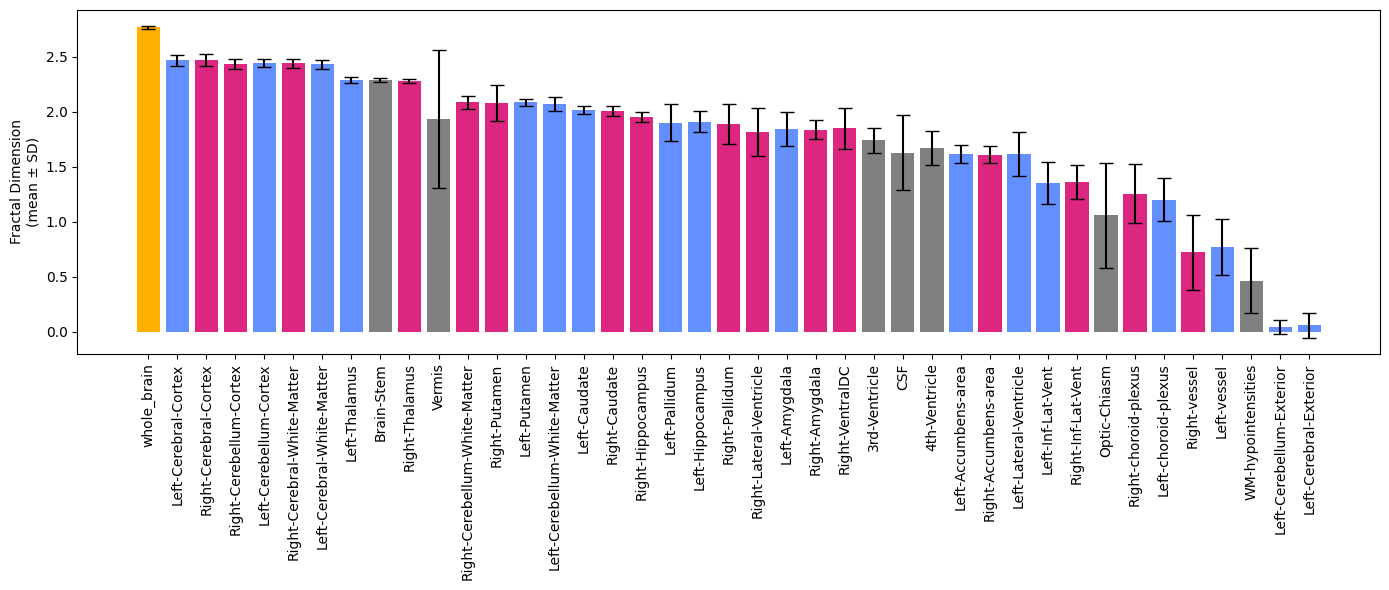

In [ ]:
means = []
stds  = []
for r in region_order:
    vals = df_fd_merged.loc[df_fd_merged['name'] == r, 'fd']
    means.append(vals.mean())
    stds.append(vals.std())

x = np.arange(len(region_order))
plt.figure(figsize=(14, 6))
bars = plt.bar(x, means,
               yerr=stds,
               capsize=5,
               color=colors)
plt.xticks(x, region_order, rotation=90)
plt.ylabel("Fractal Dimension\n(mean ± SD)")
plt.tight_layout()
plt.show()

### side comparison

In [ ]:
# Helper for Cohen's d (paired)
def cohen_d_paired(x, y):
    diff = x - y
    return diff.mean() / diff.std(ddof=1)

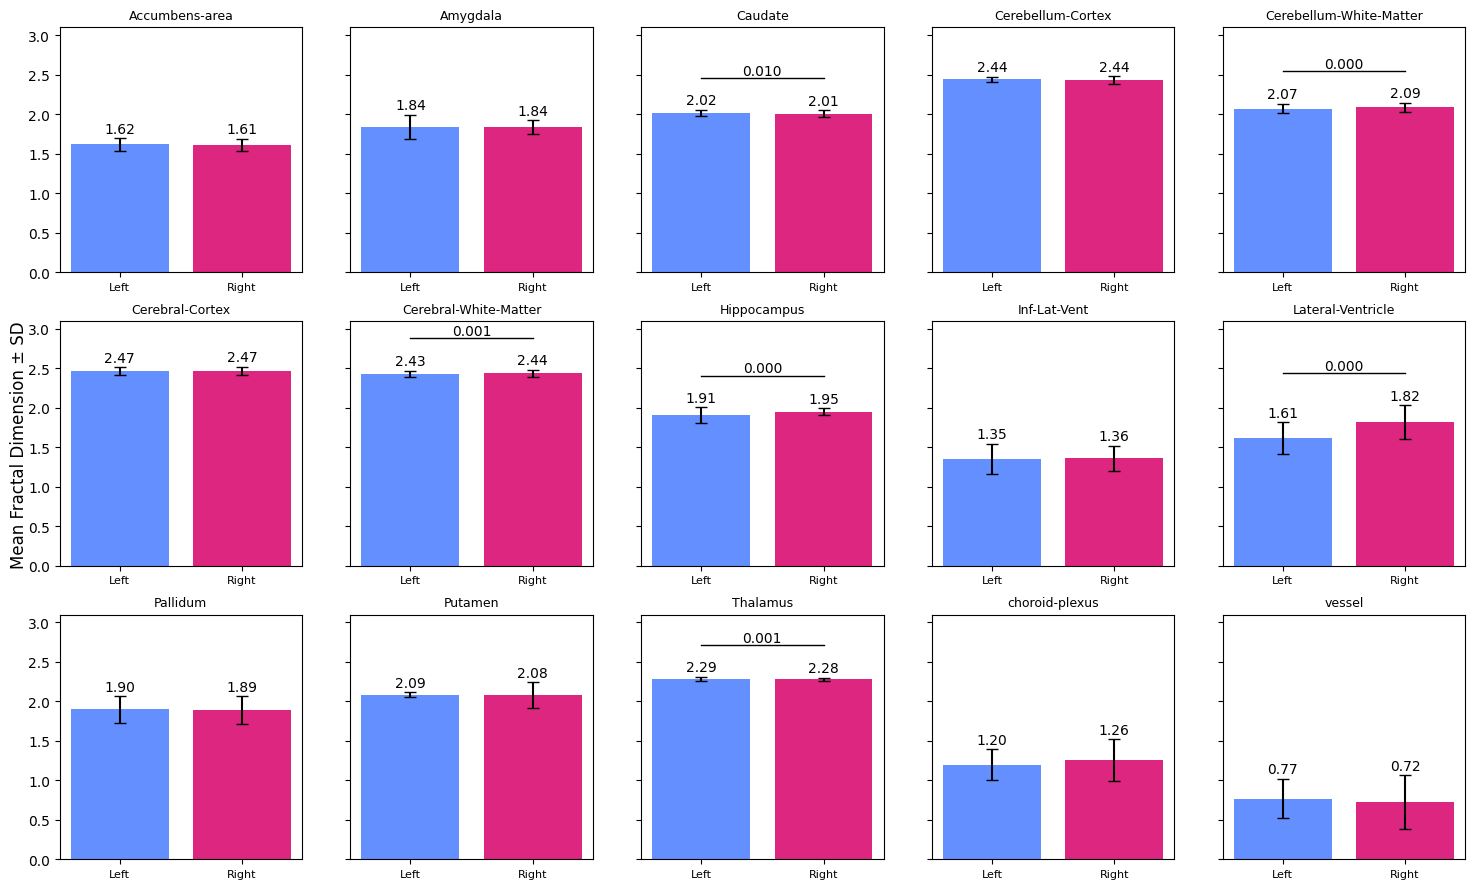

,name,FD (Left),FD (Right),FD (diff),n,p-val,d
0,Accumbens-area,1.62 ± 0.08,1.61 ± 0.08,0.01 ± 0.08,71,0.383,0.10
1,Amygdala,1.84 ± 0.15,1.84 ± 0.09,0.01 ± 0.15,71,0.734,0.04
2,Caudate,2.02 ± 0.04,2.01 ± 0.05,0.01 ± 0.04,71,0.010,0.32
3,Cerebellum-Cortex,2.44 ± 0.03,2.44 ± 0.05,0.00 ± 0.02,71,0.056,0.23
4,Cerebellum-White-Matter,2.07 ± 0.06,2.09 ± 0.06,-0.02 ± 0.02,71,0.000,-0.66
5,Cerebral-Cortex,2.47 ± 0.05,2.47 ± 0.05,0.00 ± 0.02,71,0.366,0.11
6,Cerebral-White-Matter,2.43 ± 0.04,2.44 ± 0.04,-0.01 ± 0.02,71,0.001,-0.40
7,Hippocampus,1.91 ± 0.10,1.95 ± 0.05,-0.04 ± 0.09,71,0.000,-0.49
8,Inf-Lat-Vent,1.35 ± 0.19,1.36 ± 0.16,-0.01 ± 0.24,71,0.771,-0.03
9,Lateral-Ventricle,1.61 ± 0.20,1.82 ± 0.22,-0.20 ± 0.29,71,0.000,-0.71


In [ ]:
# Copy and clean
df = df_fd_merged.copy()
df['base_name'] = df['name'].apply(lambda x: re.sub(r'^(Left-|Right-)', '', x))
df['side'] = df['name'].apply(lambda x: 'Left' if x.startswith('Left-') else 'Right')

# Identify true pairs
side_counts = df.groupby('base_name')['side'].nunique()
paired_bases = side_counts[side_counts == 2].index.tolist()
df_paired = df[df['base_name'].isin(paired_bases)]

# Compute statistics table
stats_list = []
for base in paired_bases:
    sub = df_paired[df_paired['base_name'] == base]
    pt = sub.pivot_table(index=['participant_id','session_id'],
                         columns='side', values='fd').dropna()
    left = pt['Left']
    right = pt['Right']
    diff = left - right

    mean_diff = diff.mean()
    sd_diff   = diff.std(ddof=1)
    t_stat, p_val = ttest_rel(left, right)
    d_val = cohen_d_paired(left, right)
    
    stats_list.append({
        'name': base,
        'FD (Left)': f"{left.mean():.2f} ± {left.std(ddof=1):.2f}",
        'FD (Right)': f"{right.mean():.2f} ± {right.std(ddof=1):.2f}",
        'FD (diff)': f"{mean_diff:.2f} ± {sd_diff:.2f}",
        'n': len(diff),
        'p-val': f"{p_val:.3f}",
        'd': f"{d_val:.2f}"
    })

df_stats = pd.DataFrame(stats_list)

# Bar plot of mean ± SD with significance stars
# First, compute mean and sd per side
agg = df_paired.groupby(['base_name','side'])['fd'] \
               .agg(mean='mean', sd='std') \
               .reset_index()

n_pairs = len(paired_bases)
ncols   = 5
nrows   = math.ceil(n_pairs / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharey=True)
axes = axes.flatten()

for ax, base in zip(axes, paired_bases):
    sub = agg[agg['base_name'] == base].set_index('side').loc[['Left','Right']].reset_index()
    x = np.arange(2)
    means = sub['mean'].values
    stds  = sub['sd'].values
    full_names = sub['side'] + '-' + base
    colors = [assign_color(fn) for fn in full_names]
    
    # Plot bars
    ax.bar(x, means, yerr=stds, capsize=4, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(sub['side'], fontsize=8)
    ax.set_title(base, fontsize=9)
    
    # Annotate mean values
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd + 0.03, f"{m:.2f}", ha='center', va='bottom', fontsize=10)
    
    # Significance star
    row = df_stats[df_stats['name'] == base].iloc[0]
    p = float(row['p-val'])

    if p < 0.05:
        # coordinates
        y0 = max(means + stds) + 0.4           # base height of line
        # draw horizontal line 
        ax.plot([x[0], x[1]], [y0, y0], color='black', linewidth=1)
        # add the star centered
        ax.text((x[0]+x[1])/2, y0 + 0.005, f"{p:.3f}",
                ha='center', va='bottom', fontsize=10)

# Turn off extras
for ax in axes[n_pairs:]:
    ax.axis('off')

fig.supylabel("Mean Fractal Dimension ± SD")
plt.setp(axes, ylim=(0, 3.1))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

df_stats


Display only the significant differences, after aplying Bonferroni correction for multiple comparison:

In [110]:
# number of paired tests
n_tests = len(df_stats)
alpha_corr = 0.05 / n_tests

df_stats['p_nominal'] = df_stats['p-val'].astype(float)
df_stats['sign_corr'] = df_stats['p_nominal'] < alpha_corr

print(f"Bonferroni α = {alpha_corr:.4f}")
df_stats.loc[df_stats['sign_corr'], ['name', 'FD (Left)', 'FD (Right)', 'FD (diff)', 'p-val', 'd']]

Bonferroni α = 0.0033


,name,FD (Left),FD (Right),FD (diff),p-val,d
4,Cerebellum-White-Matter,2.07 ± 0.06,2.09 ± 0.06,-0.02 ± 0.02,0.000,-0.66
6,Cerebral-White-Matter,2.43 ± 0.04,2.44 ± 0.04,-0.01 ± 0.02,0.001,-0.40
7,Hippocampus,1.91 ± 0.10,1.95 ± 0.05,-0.04 ± 0.09,0.000,-0.49
9,Lateral-Ventricle,1.61 ± 0.20,1.82 ± 0.22,-0.20 ± 0.29,0.000,-0.71
12,Thalamus,2.29 ± 0.03,2.28 ± 0.02,0.01 ± 0.02,0.001,0.43


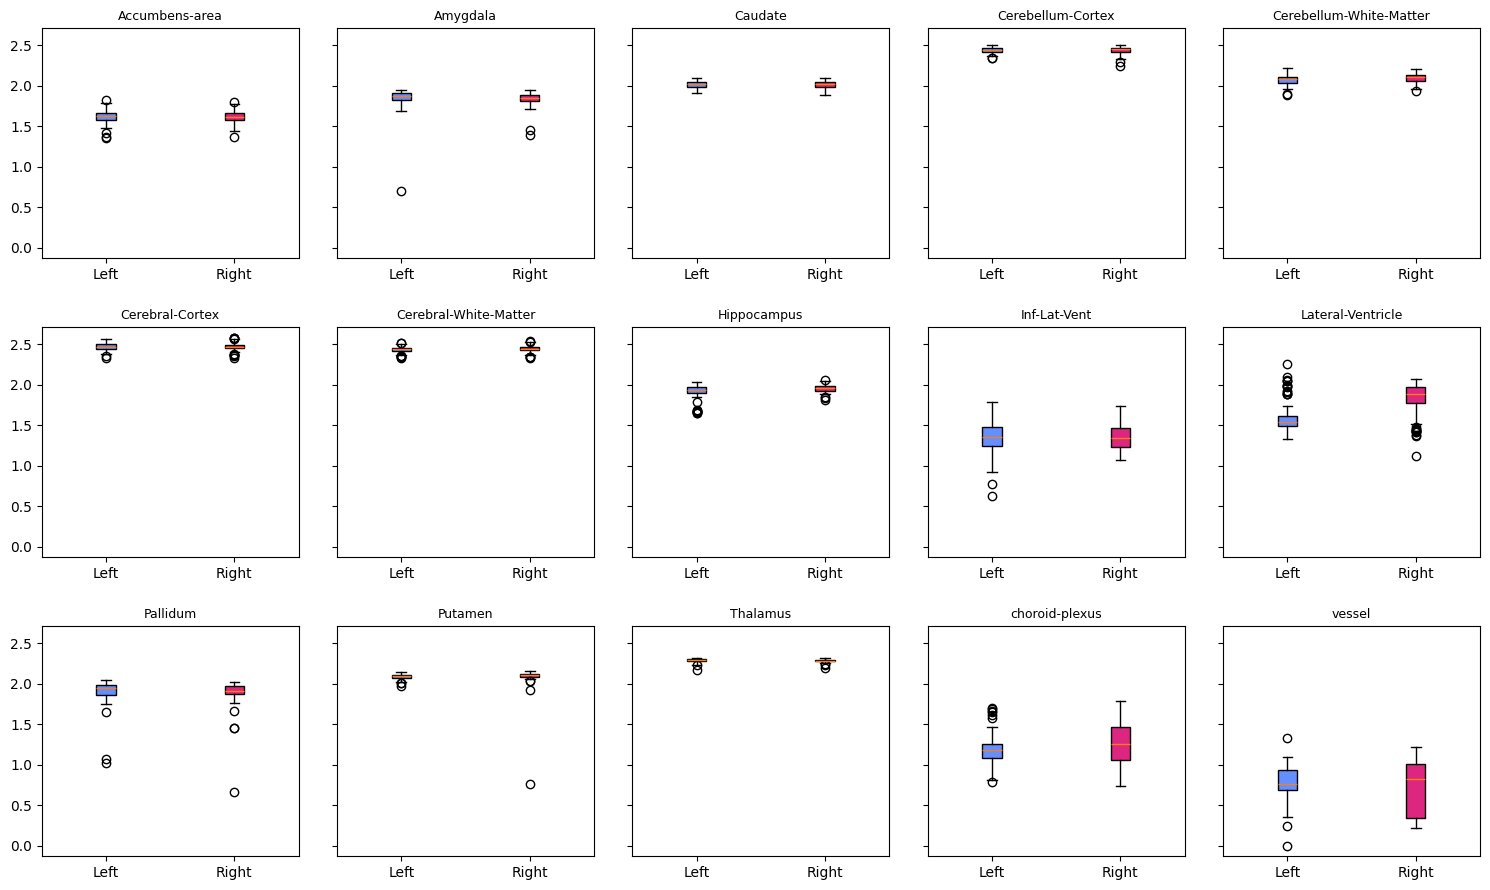

In [80]:
# Boxplots
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols * 3, nrows * 3),
                         sharey=True)
axes = axes.flatten()

for ax, base in zip(axes, paired_bases):
    sub = df[df['base_name'] == base]

    data_left  = sub.loc[sub['side']=='Left', 'fd']
    data_right = sub.loc[sub['side']=='Right','fd']
    data       = [data_left, data_right]
    labels     = ['Left', 'Right']
    colors     = [assign_color(f"Left-{base}"),
                  assign_color(f"Right-{base}")]

    bp = ax.boxplot(data,
                    tick_labels=labels,
                    patch_artist=True,
                    showfliers=True)
    # color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(base, fontsize=9)
    ax.tick_params(axis='x', labelrotation=0, labelsize=10)

# turn off any extras
for ax in axes[n_pairs:]:
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.15)
plt.show()

### FD over age

In [113]:
df = df_fd_merged.copy()
len(df['name'].unique())

41

We have 41 different regions for the FD results. Differences between left and right were below 0.05 for all except Lateral-Ventricle.

For a better overview, I will only plot FD over age for 
1. where we have FDs for all brains
2. the Left side and 
3. only for regions that have an FD > 1. 

In [138]:
df = df[~df['name'].isin(not_complete)]
df['base_name'] = df['name'].str.replace(r'^(Left-|Right-)', '', regex=True)

# mark Left, right vs. “neutral”
is_left    = df['name'].str.startswith('Left-')
is_right   = df['name'].str.startswith('Right-')
is_neutral = ~(is_left | is_right)

# filter to only Left or neutral regions
df_filtered = df[is_left | is_neutral].copy()

mean_fd = df_filtered.groupby('base_name')['fd'].mean()

# pick those base_names whose mean FD > 1
good_bases = mean_fd[mean_fd > 1].index.tolist()
df_final = df_filtered[df_filtered['base_name'].isin(good_bases)].reset_index(drop=True)
df_final.head()

,participant_id,session_id,label,name,fd,min_box_size,max_box_size,age,gestational_age_at_birth,sex,base_name,side
0,sub-116056,ses-3mo,NaN,whole_brain,2.7598,1.0,16.0,3.6,40.4,Male,whole_brain,Right
1,sub-116056,ses-3mo,2.0,Left-Cerebral-White-Matter,2.4704,1.0,16.0,3.6,40.4,Male,Cerebral-White-Matter,Left
2,sub-116056,ses-3mo,3.0,Left-Cerebral-Cortex,2.4475,1.0,16.0,3.6,40.4,Male,Cerebral-Cortex,Left
3,sub-116056,ses-3mo,4.0,Left-Lateral-Ventricle,1.5052,4.0,64.0,3.6,40.4,Male,Lateral-Ventricle,Left
4,sub-116056,ses-3mo,5.0,Left-Inf-Lat-Vent,1.3861,1.0,16.0,3.6,40.4,Male,Inf-Lat-Vent,Left


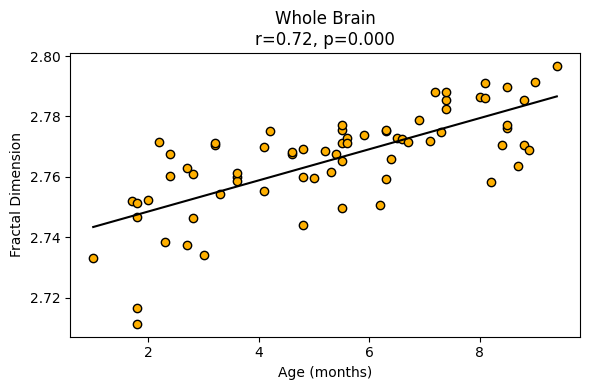

In [140]:
wb = df_final[df_final['base_name'] == 'whole_brain']
ages, fds = wb['age'].values, wb['fd'].values

# linear fit + stats
slope, intercept = np.polyfit(ages, fds, 1)
x_line = np.linspace(ages.min(), ages.max(), 100)
y_line = slope * x_line + intercept
r_val, p_val = pearsonr(ages, fds)

plt.figure(figsize=(6,4))
plt.scatter(ages, fds, c='#FFB000', edgecolor='k')
plt.plot(x_line, y_line, color='black')
plt.xlabel("Age (months)")
plt.ylabel("Fractal Dimension")
plt.title(f"Whole Brain\nr={r_val:.2f}, p={p_val:.3f}")
plt.tight_layout()
plt.show()

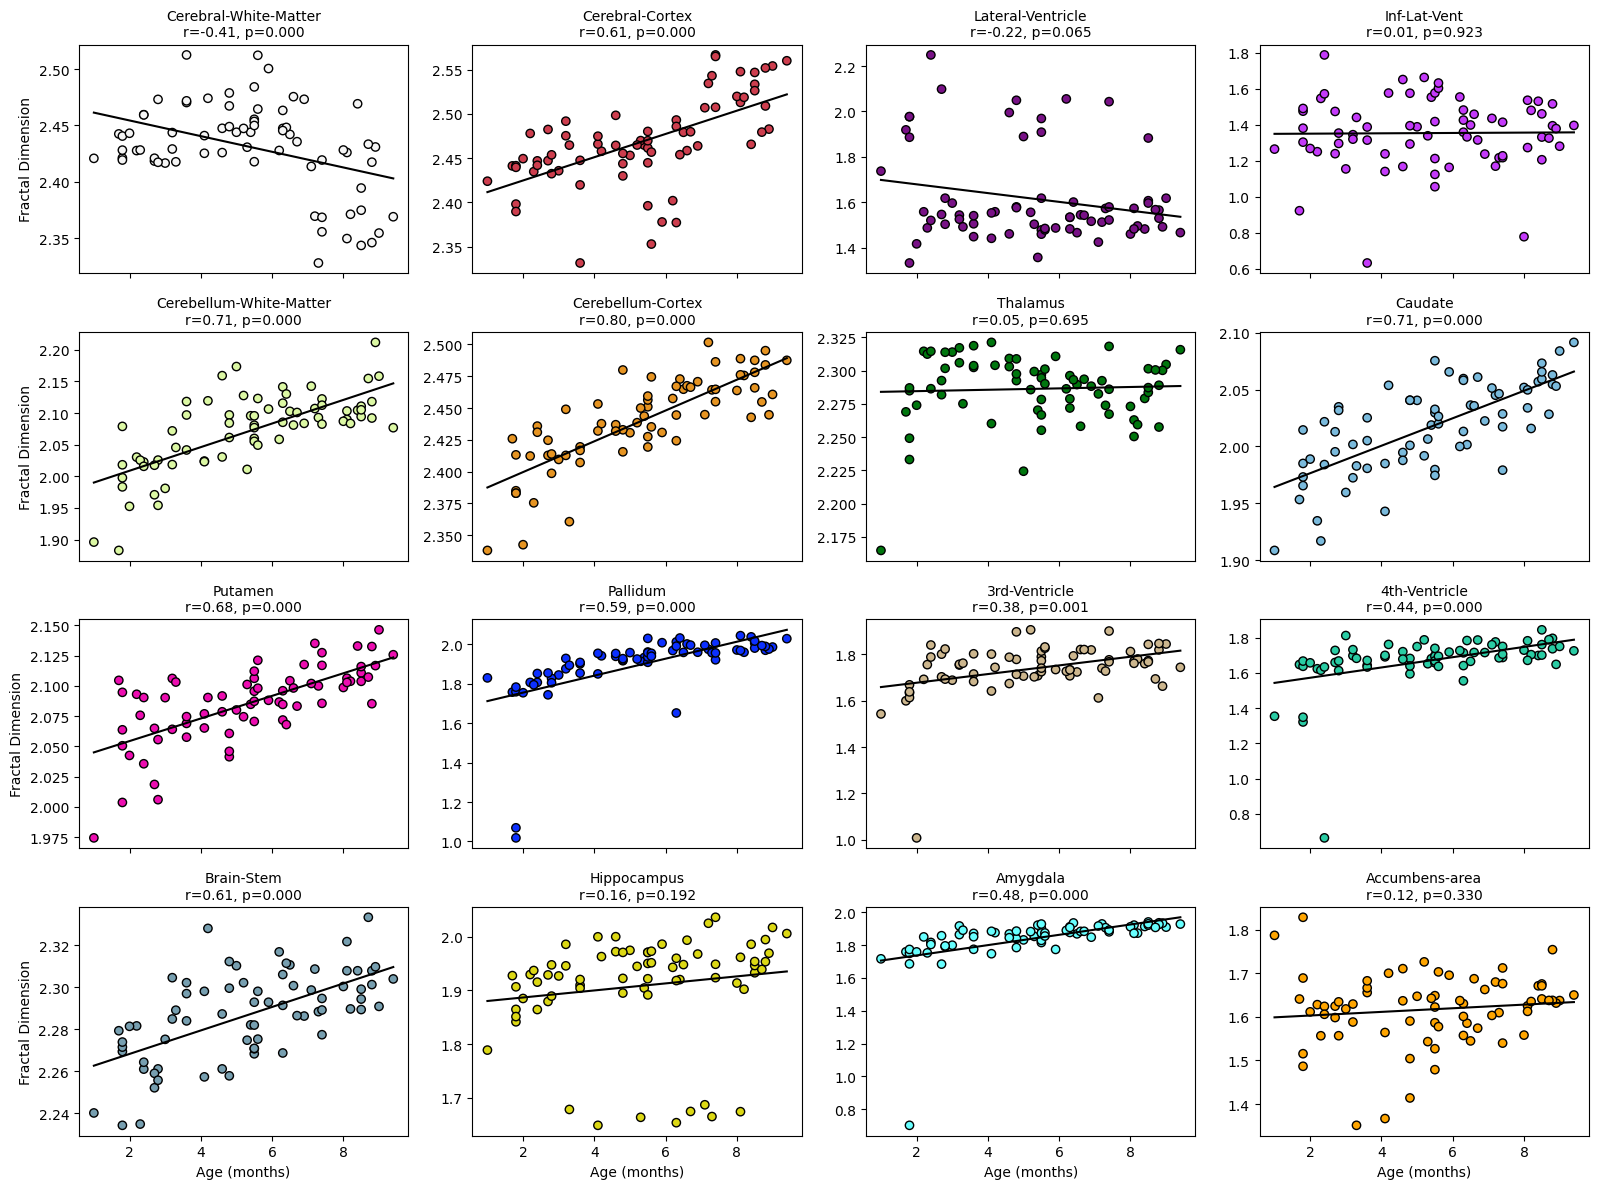

In [144]:
index_to_color = dict(zip(BOB_idx_lbl['index'], BOB_idx_lbl['color']))

base_list = [b for b in df_final['base_name'].unique() if b != 'whole_brain']
n = len(base_list)

# Define grid layout
ncols = 4
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols * 4, nrows * 3),
                         sharex=True)
axes = axes.flatten()

for idx, base in enumerate(base_list):
    ax = axes[idx]
    sub = df_final[df_final['base_name'] == base]
    ages = sub['age'].values
    fds  = sub['fd'].values
    colors = sub['label'].map(index_to_color)

    # Fit linear model
    slope, intercept = np.polyfit(ages, fds, 1)
    x_line = np.linspace(ages.min(), ages.max(), 100)
    y_line = slope * x_line + intercept

    # Compute Pearson r and p-value
    r_val, p_val = pearsonr(ages, fds)

    # Plot scatter + regression line
    ax.scatter(ages, fds, c=colors, edgecolor='k')
    ax.plot(x_line, y_line, color='black')
    ax.set_title(f"{base}\nr={r_val:.2f}, p={p_val:.3f}", fontsize=10)
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Age (months)")
    if idx % ncols == 0:
       ax.set_ylabel("Fractal Dimension")

# Turn off any unused subplots
for j in range(n, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()